<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Function-Fit" data-toc-modified-id="Function-Fit-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Function Fit</a></span></li><li><span><a href="#Fit-test-based-on-Single-Pixel-from-all-TE" data-toc-modified-id="Fit-test-based-on-Single-Pixel-from-all-TE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit test based on Single Pixel from all TE</a></span></li><li><span><a href="#Estimate-Images-of-Each-Component" data-toc-modified-id="Estimate-Images-of-Each-Component-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Estimate Images of Each Component</a></span></li></ul></div>

In [1]:
# Modules
import pydicom as dcm
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import expanduser
import os

import matplotlib.pylab as plt
import numpy as np
import math
import plot as plot
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
# Modules
from mpl_toolkits.axes_grid1 import ImageGrid
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, HBox
from mpl_toolkits.axes_grid1 import make_axes_locatable

# load Bruker raw reader module
import brukerMRI_reader as bruker
# load modules
import pylab as plt
import numpy as np

# A realistic model for m1_3

Given that the current data set contains multiple components of fat, a more robust equation representing the different components in the sample can theoretically be modeled. All data files acquired at the multiple TEs are used to obtain this theoretical fit.

Water at 4.7ppm. Main fat peaks ppm: 6.7, 1.718, 1.162, 0.863, 0.581

In [2]:
from scipy.optimize import curve_fit

## Function Fit

In [3]:
img_file = np.array([[10,2.606],
                      [13,3.257],
                      [17,3.571],
                      [18,4.4],
                      [19,3],
                      [20,3.25],
                      [27,3.75],
                      [23,4],
                      [29,4.6],
                      [31,5.2],
                      [32,6],
                      [33,6.6]])

$$
\begin{align}
sig  = (ae^{4.7fT_{E,i}} + be^{6.7fT_{E,i}} + ce^{1.718fT_{E,i}} + de^{1.162fT_{E,i}} + fe^{0.863fT_{E,i}} + ge^{0.581fT_{E,i}}) e^{i\phi_0}
\tag{13}
\end{align}
$$ 

In [4]:
def func_full(t,a,b,c,d,e,g,w):
    f = 2*np.pi*400
    sig_real = (a * np.cos(4.7*t*f) +b * np.cos(6.7*t*f) + c * np.cos(1.718*t*f) 
    + d * np.cos(1.162*t*f) + e * np.cos(0.863*t*f) + g * np.cos(0.581*t*f))*np.cos(w*f)
    sig_imag = (a * np.sin(4.7*t*f) +b * np.sin(6.7*t*f) + c * np.sin(1.718*t*f) 
    + d * np.sin(1.162*t*f) + e * np.sin(0.863*t*f) + g * np.sin(0.581*t*f))*np.sin(w*f)
    sig = np.abs(sig_real+sig_imag*1j)
    return sig

In [5]:
# Select data to reconstruct
def recon_fat_water(exp_number):
    series = exp_number
    path = "/Users/admin/Desktop/brukerMRI-master/scans/w_p/"  # access to mapped MRT network dri
    Exp = bruker.ReadExperiment(path,series)

    # Full recon steps
    recopart = ['quadrature', 'phase_rotate', 'zero_filling', 'FT', 'cutoff']
    Exp.bruker_reco(recopart)
    img = Exp.image
    
    return img

## Fit test based on Single Pixel from all TE

The average value of the central signal of the image is used to test the validity of the fit function that accounts for both the complex and real components,

In [6]:
def ydata(file):
    fw_y = np.empty((file.shape[0]))
    
    for i in range(0,file.shape[0]):
        m1_3 = recon_fat_water(int(file[i,0]))
        m1_3 = m1_3.reshape([128,128])
        m1_central = np.sum(m1_3[64,50:60])/10
        fw_y[i] = m1_central
        print(file[i])
    return fw_y

In [7]:
ydata = ydata(img_file)

No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[10.     2.606]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[13.     3.257]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[17.     3.571]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[18.   4.4]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[19.  3.]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[20.    3.25]
No information about active channels available.
assuming number of channels = 1
quadrature
phase_rotate
zero_filling
FT
cutoff
[27.    3.75]
No informatio

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [8]:
popt, pcov = curve_fit(func_full, img_file[:,1], ydata)

In [9]:
fit = func_full(img_file[:,1],*popt)
fit

array([179142.48059205,  23381.72111625, 109849.23113632,  56440.52969299,
        87309.61902423,   1889.84803252,  59131.45802524,   6908.32445379,
          513.45768037,  95252.78157991,   6908.3244538 ,  51115.60262383])

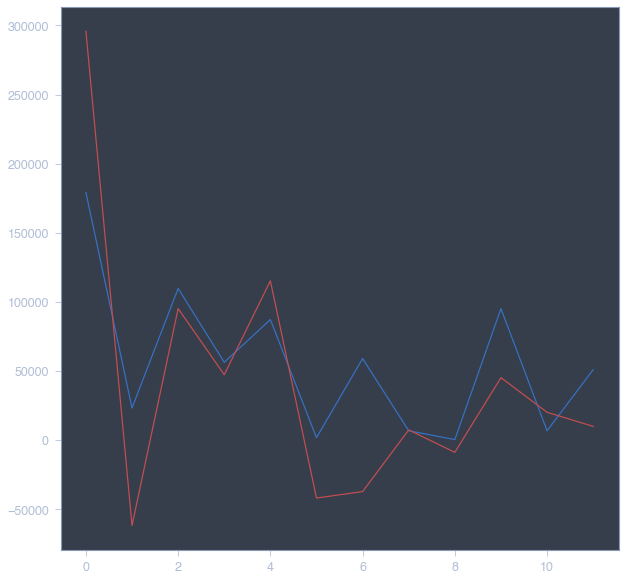

In [10]:
plt.figure(figsize=(10,10))
plt.plot(fit,'b')
plt.plot(ydata,'r')

In [11]:
popt

array([  89186.95093336, -126522.1968536 ,  -32939.36337449,
         41573.89733297,   46872.68087335,  -16434.7970659 ,
           483.61374382])

In [13]:
peaks = np.array([4.7,6.7, 1.718, 1.162, 0.863, 0.581])
intensity = np.abs(popt.copy())

([<matplotlib.axis.XTick at 0x1a1b18eb10>,
 <a list of 6 Text xticklabel objects>)

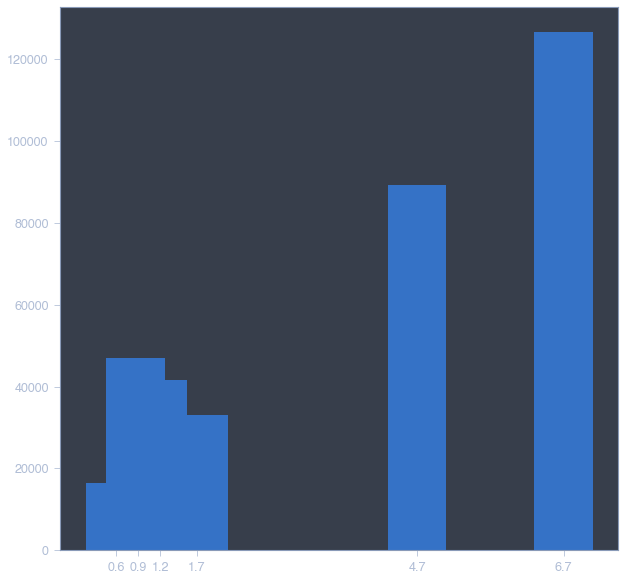

In [21]:
plt.figure(figsize=(10,10))
plt.bar(peaks,intensity[0:6])
plt.xticks((4.7,6.7,1.7,1.2,0.9,0.6))

## Estimate Images of Each Component

In [22]:
import BrukerMRI as bruker2
import matplotlib.pyplot as plt

images = np.zeros((img_file.shape[0],128,128),dtype='complex')

for i in range(img_file.shape[0]):
    MainDir = "/Users/admin/Desktop/brukerMRI-master/scans/w_p/"
    ExpNum = int(img_file[i,0])
    Experiment = bruker2.ReadExperiment(MainDir, ExpNum)
    kdata = Experiment.raw_fid.astype(np.complex64)
    kdata=np.reshape(kdata,[128,128])
    rawdata=np.fft.fftshift(np.fft.fftn(kdata,axes=(0,1),norm='ortho'),[0,1])
    intensity = rawdata
    images[i,:,:]=intensity

In [23]:
images.shape

(12, 128, 128)

In [26]:
img_est = np.empty((7,128,128),'complex')
    
for i in range(0,images.shape[1]):
    for k in range(0,images.shape[2]):
        points_full = np.abs(images[:,i,k])
        popt, pcov = curve_fit(func_full, img_file[:,1], points_full)
        img_est[:,i,k] = popt 

Text(0.5, 1.0, 'Estimated Water Image Using Realistic Model')

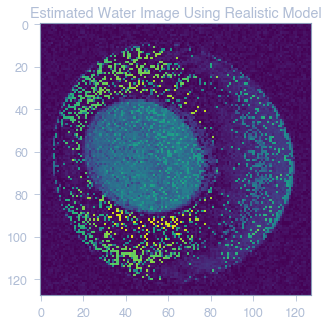

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(np.abs(img_est[0,:,:]))
plt.title('Estimated Water Image Using Realistic Model')

In [30]:
def perc(image,image_comp,r,c):
    
    key_list = list(image_comp)
    
    plt.figure(figsize=(r,c))

    for key,value in image_comp.items():
        
        plt.subplot((100*math.ceil(len(key_list)/2))+21+key_list.index(key))
        image1 = np.reshape(value,(128,128))
        perc = (np.sum(np.abs(image1))/np.sum(np.abs(image)))*100
        plt.imshow(np.abs(image1))
        plt.title( 'Percentage of '+ key + ' in Image: '+ str(perc)+ ' %')
        plt.colorbar()
        plt.subplots_adjust(hspace=0.2)
        plt.subplots_adjust(wspace=0)

In [39]:
image = img_est[0,:,:]+img_est[1,:,:]+img_est[2,:,:]+img_est[3,:,:]+img_est[4,:,:]+img_est[5,:,:]

In [41]:
img_est_plots = {"Water, 4.7ppm" :img_est[0,:,:],
                "Fat 1, 6.7ppm" :img_est[1,:,:],
                "Fat 2, 1.7ppm" :img_est[2,:,:],
                "Fat 3, 1.2ppm" :img_est[3,:,:],
                "Fat 4, 0.9ppm" :img_est[4,:,:],
                "Fat 5, 0.6ppm" :img_est[5,:,:]
                }

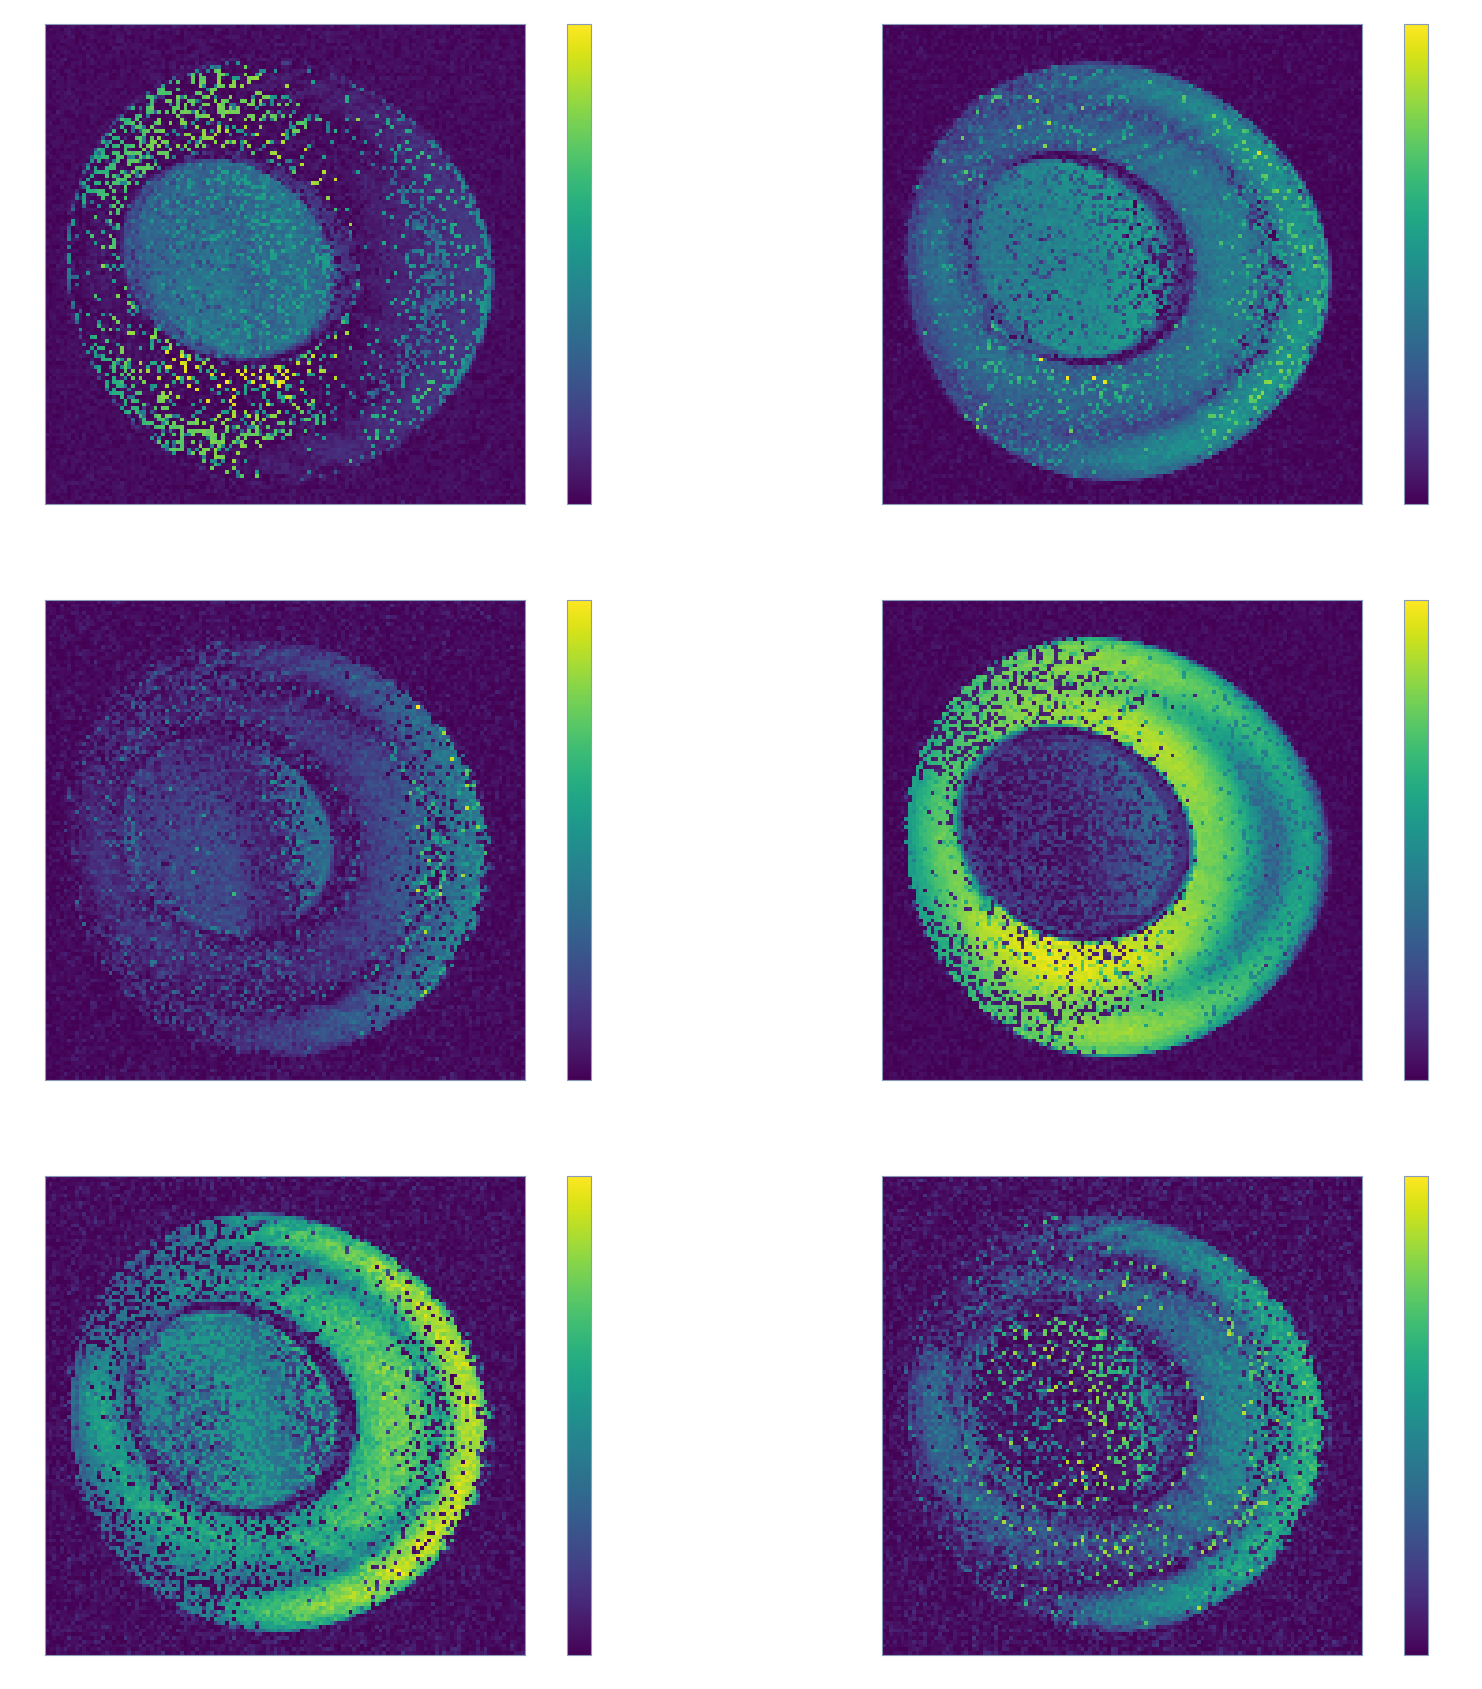

In [43]:
perc(image,img_est_plots,30,30)